In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, random

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

import functools

import tensorflow_probability.substrates.jax as tfp
tfpd = tfp.distributions
tfpb = tfp.bijectors

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
# from jaxns import analytic_log_evidence
from jaxns import Prior, Model

/opt/homebrew/anaconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
INFO[2023-06-29 14:41:03,325]: Remote TPU is not linked into jax; skipping remote TPU.
INFO[2023-06-29 14:41:03,326]: Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO[2023-06-29 14:41:03,326]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-29 14:41:03,326]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-29 14:41:03,327]: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO[2023-06-29 14:41:03,327]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:ena

In [3]:
def get_kernel(kernel_type, kernel_params):
    """
    Function for producing the kernel for the Gaussian Process.
    Returns the selected Tinygp kernel

    Parameters
    ----------
    kernel_type: string
        The type of kernel to be used for the Gaussian Process
        To be selected from the kernels already implemented

    kernel_params: dict
        Dictionary containing the parameters for the kernel
        Should contain the parameters for the selected kernel

    """
    if kernel_type == "QPO_plus_RN":
        kernel = kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        ) + kernels.quasisep.Celerite(
            a=kernel_params["aqpo"],
            b=0.0,
            c=kernel_params["cqpo"],
            d=2 * jnp.pi * kernel_params["freq"],
        )
        return kernel
    elif kernel_type == "RN":
        kernel = kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        )
        return kernel


def get_mean(mean_type, mean_params):
    """
    Function for producing the mean for the Gaussian Process.

    Parameters
    ----------
    mean_type: string
        The type of mean to be used for the Gaussian Process
        To be selected from the mean functions already implemented

    mean_params: dict
        Dictionary containing the parameters for the mean
        Should contain the parameters for the selected mean

    """
    if mean_type == "gaussian":
        mean = functools.partial(_gaussian, mean_params=mean_params)
    elif mean_type == "exponential":
        mean = functools.partial(_exponential, mean_params=mean_params)
    elif mean_type == "constant":
        mean = functools.partial(_constant, mean_params=mean_params)
    elif mean_type == "skew_gaussian":
        mean = functools.partial(_skew_gaussian, mean_params=mean_params)
    elif mean_type == "skew_exponential":
        mean = functools.partial(_skew_exponential, mean_params=mean_params)
    elif mean_type == "fred":
        mean = functools.partial(_fred, mean_params=mean_params)
    return mean


def _gaussian(t, mean_params):
    """A gaussian flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    sig1:
        The width parameter for the gaussian.

    Returns
    -------
    The y values for the gaussian flare.
    """
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig = jnp.atleast_1d(mean_params["sig"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.exp(
        -((t - t0) ** 2) / (2 * (sig ** 2))
    )
    , axis=0)


def _exponential(t, mean_params):
    """An exponential flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    sig1:
        The width parameter for the exponential.

    Returns
    -------
    The y values for exponential flare.
    """
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig = jnp.atleast_1d(mean_params["sig"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.exp(
        -jnp.abs(t - t0) / (2 * (sig ** 2))
    )
    , axis=0)

def _constant(t, mean_params):
    """A constant mean shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Constant amplitude of the flare.

    Returns
    -------
    The constant value.
    """
    return mean_params["A"] * jnp.ones_like(t)


def _skew_gaussian(t, mean_params):
    """A skew gaussian flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    sig1:
        The width parameter for the rising edge.
    sig2:
        The width parameter for the falling edge.

    Returns
    -------
    The y values for skew gaussian flare.
    """
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig1 = jnp.atleast_1d(mean_params["sig1"])[:,jnp.newaxis]
    sig2 = jnp.atleast_1d(mean_params["sig2"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.where (
        t > t0 , 
        jnp.exp(-((t - t0) ** 2) / (2 * (sig2 ** 2))),
        jnp.exp(-((t - t0) ** 2) / (2 * (sig1 ** 2))),       
        )
    , axis=0)


def _skew_exponential(t, mean_params):
    """A skew exponential flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    sig1:
        The width parameter for the rising edge.
    sig2:
        The width parameter for the falling edge.

    Returns
    -------
    The y values for exponential flare.
    """
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig1 = jnp.atleast_1d(mean_params["sig1"])[:,jnp.newaxis]
    sig2 = jnp.atleast_1d(mean_params["sig2"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.where (
        t > t0 , 
        jnp.exp(-(t - t0) / (2 * (sig2 ** 2))),
        jnp.exp((t - t0) / (2 * (sig1 ** 2))),       
        )
    , axis=0)


def _fred(t, mean_params):
    """A fast rise exponential decay (FRED) flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    phi:
        Symmetry parameter of the flare.
    delta:
        Offset parameter of the flare.

    Returns
    -------
    The y values for exponential flare.
    """
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    phi = jnp.atleast_1d(mean_params["phi"])[:,jnp.newaxis]
    delta = jnp.atleast_1d(mean_params["delta"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.exp(
            -phi
            * (
                (t + delta )/ t0
                + t0 / (t + delta)
            )
        )
        * jnp.exp(2 * phi)
    , axis=0)


def get_kernel_params(kernel_type):
    if kernel_type == "RN":
        return ["arn", "crn"]
    elif kernel_type == "QPO_plus_RN":
        return ["arn", "crn", "aqpo", "cqpo", "freq"]


def get_mean_params(mean_type):
    if (mean_type == "gaussian") or (mean_type == "exponential"):
        return ["A", "t0", "sig"]
    elif mean_type == "constant":
        return ["A"]
    elif (mean_type == "skew_gaussian") or (mean_type == "skew_exponential"):
        return ["A", "t0", "sig1", "sig2"]
    elif mean_type == "fred":
        return ["A", "t0", "delta", "phi"]


def get_gp_params(kernel_type, mean_type):
    kernel_params = get_kernel_params(kernel_type)
    mean_params = get_mean_params(mean_type)
    kernel_params.extend(mean_params)
    return kernel_params


def get_prior(params_list, prior_dict):
    """
    A prior generator function based on given values

    Parameters
    ----------
    params_list:
        A list in order of the parameters to be used.

    prior_dict:
        A dictionary of the priors of parameters to be used.

    Returns
    -------
    The Prior function.
    The arguments of the prior function are in the order of
    Kernel arguments (RN arguments, QPO arguments),
    Mean arguments
    Non Windowed arguments

    """

    def prior_model():
        prior_list = []
        for i in params_list:
            if isinstance(prior_dict[i], tfpd.Distribution):
                parameter = yield Prior(prior_dict[i], name=i)
            else:
                parameter = yield prior_dict[i]
            prior_list.append(parameter)
        return tuple(prior_list)

    return prior_model


def get_likelihood(params_list, kernel_type, mean_type, **kwargs):
    """
    A likelihood generator function based on given values

    Parameters
    ----------
    params_list:
        A list in order of the parameters to be used.

    prior_dict:
        A dictionary of the priors of parameters to be used.

    kernel_type:
        The type of kernel to be used in the model.

    mean_type:
        The type of mean to be used in the model.

    """

    @jit
    def likelihood_model(*args):
        dict = {}
        for i, params in enumerate(params_list):
            dict[params] = args[i]
        kernel = get_kernel(kernel_type=kernel_type, kernel_params=dict)
        mean = get_mean(mean_type=mean_type, mean_params=dict)
        gp = GaussianProcess(kernel, kwargs["Times"], mean_value=mean(kwargs["Times"]))
        return gp.log_probability(kwargs["counts"])
    
    def widowed_likelihood_modle(*args):
        
        pass

    return likelihood_model


class GP:
    """
    Makes a GP object which takes in a Stingray.Lightcurve and fits a Gaussian
    Process on the lightcurve data, for the given kernel.

    Parameters
    ----------
    lc: Stingray.Lightcurve object
        The lightcurve on which the gaussian process, is to be fitted

    Model_type: string tuple
        Has two strings with the first being the name of the kernel type
        and the secound being the mean type

    Model_parameter: dict, default = None
        Dictionary conatining the parameters for the mean and kernel
        The keys should be accourding to the selected kernel and mean
        coressponding to the Model_type
        By default, it takes a value None, and the kernel and mean are
        then bulit using the pre-set parameters.

    Other Parameters
    ----------------
    kernel: class: `TinyGp.kernel` object
        The tinygp kernel for the GP

    mean: class: `TinyGp.mean` object
        The tinygp mean for the GP

    maingp: class: `TinyGp.GaussianProcess` object
        The tinygp gaussian process made on the lightcurve

    """

    def __init__(self, Lc: Lightcurve) -> None:
        self.lc = Lc
        self.time = Lc.time
        self.counts = Lc.counts

    def fit(self, kernel=None, mean=None, **kwargs):
        self.kernel = kernel
        self.mean = mean

        return  GaussianProcess(
            self.kernel, self.time, mean_value=self.mean(self.time), diag=kwargs["diag"]
        )

    def get_logprob(self):
        """
        Returns the logprobability of the lightcurves counts for the
        given kernel for the Gaussian Process
        """
        cond = self.maingp.condition(self.lc.counts)
        return cond.log_probability

    def plot_kernel(self):
        """
        Plots the kernel of the Gaussian Process
        """
        X = self.lc.time
        Y = self.kernel(X, np.array([0.0]))
        plt.plot(X, Y)
        plt.xlabel("distance")
        plt.ylabel("Value")
        plt.title("Kernel Function")

    def plot_originalgp(self, gp, sample_no=1, seed=0):
        """
        Plots samples obtained from the gaussian process for the kernel

        Parameters
        ----------
        gp: class: `TinyGp.GaussianProcess` object
            The tinygp gaussian process made on the lightcurve

        sample_no: int , default = 1
            Number of GP samples to be taken

        """
        X_test = self.lc.time
        _, ax = plt.subplots(1, 1, figsize=(10, 3))
        y_samp = gp.sample(jax.random.PRNGKey(seed), shape=(sample_no,))
        ax.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
        ax.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)
        ax.set_xlabel("time")
        ax.set_ylabel("counts")
        ax.legend(loc="best")

    def plot_gp(self, gp, sample_no=1, seed=0):
        """
        Plots gaussian process, conditioned on the lightcurve
        Also, plots the lightcurve along with it

        Parameters
        ----------
        gp: class: `TinyGp.GaussianProcess` object
            The tinygp gaussian process made on the lightcurve

        sample_no: int , default = 1
            Number of GP samples to be taken

        """
        X_test = self.lc.time

        _, ax = plt.subplots(1, 1, figsize=(10, 3))
        _, cond_gp = gp.condition(self.lc.counts, X_test)
        mu = cond_gp.mean
        # std = np.sqrt(cond_gp.variance)

        ax.plot(self.lc.time, self.lc.counts, lw=2, color="blue", label="Lightcurve")
        ax.plot(X_test, mu, "C1", label="Gaussian Process")
        y_samp = cond_gp.sample(jax.random.PRNGKey(seed), shape=(sample_no,))
        ax.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5)
        ax.set_xlabel("time")
        ax.set_ylabel("counts")
        ax.legend(loc="best")

    def sample(self, prior_model=None, likelihood_model=None, **kwargs):
        """
        Makes a Jaxns nested sampler over the Gaussian Process, given the
        prior and likelihood model

        Parameters
        ----------
        prior_model: jaxns.prior.PriorModelType object
            A prior generator object

        likelihood_model: jaxns.types.LikelihoodType object
            A likelihood fucntion which takes in the arguments of the prior
            model and returns the loglikelihood of the model

        Returns
        ----------
        Results: jaxns.results.NestedSamplerResults object
            The results of the nested sampling process

        """

        self.prior_model = prior_model
        self.likelihood_model = likelihood_model

        NSmodel = Model(prior_model=self.prior_model, log_likelihood=self.likelihood_model)
        NSmodel.sanity_check(random.PRNGKey(10), S=100)

        self.Exact_ns = ExactNestedSampler(NSmodel, num_live_points=500, max_samples=1e4)
        Termination_reason, State = self.Exact_ns(
            random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4)
        )
        print("Simulation Complete")
        return self.Exact_ns.to_results(State, Termination_reason)
    
    def analytic_log_evidence(self):
        """
        Returns the analytic log evidence for the model on the lightcurve
        """
        pass

    def print_summary(self, Results):
        """
        Prints a summary table for the model parameters
        """
        self.Exact_ns.summary(Results)

    def plot_diagnostics(self, Results):
        """
        Plots the diagnostic plots for the sampling process
        """
        self.Exact_ns.plot_diagnostics(Results)

    def plot_cornerplot(self, Results):
        """
        Plots the corner plot for the sampled hyperparameters
        """
        self.Exact_ns.plot_cornerplot(Results)

    def get_parameters(self):
        """
        Returns the optimal parameters for the model based on the NUTS sampling
        """

        pass

    def plot_posterior(self, X_test):
        """
        Plots posterior gaussian process, conditioned on the lightcurve
        Also, plots the lightcurve along with it

        Parameters
        ----------
        X_test: jnp.array
            Array over which the Gaussian process values are to be obtained
            Can be made default with lc.times as default

        """

        pass



In [ ]:
# Testing on data:-
import tinygp

# MAKING THE DATA
Times = np.linspace(0,1,256)

kernel = kernel = kernels.quasisep.Exp(
                scale = 1/jnp.exp(1.0), sigma = (jnp.exp(1.0))**0.5) + kernels.quasisep.Celerite(
                a = jnp.exp(-2), b = 0.0, c = jnp.exp(1), d = 2*jnp.pi*20)

# mean = get_mean(mean_type = "gaussian", 
#                     mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), "sig" : jnp.array([0.2, 0.1]) })
mean = get_mean(mean_type = "skew_gaussian", 
                    mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), "sig1" : jnp.array([0.2, 0.1]), "sig2" : jnp.array([0.3, 0.4]),  })


hqpogp = tinygp.GaussianProcess( kernel, Times, mean_value = mean(Times) , diag = 0.01)
counts = hqpogp.sample(jax.random.PRNGKey(101))
lightcurve = Lightcurve(Times, counts)

INFO[2023-06-29 18:34:04,582]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-06-29 18:34:04,586]: Checking if light curve is sorted.
INFO[2023-06-29 18:34:04,587]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


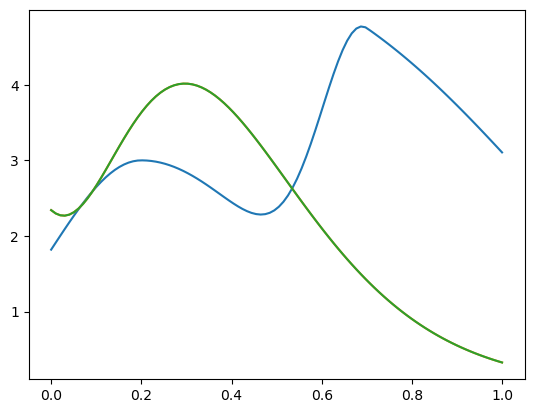

In [10]:
mean = get_mean(mean_type = "skew_gaussian", 
                    mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), "sig1" : jnp.array([0.2, 0.1]), "sig2" : jnp.array([0.3, 0.4]),  })

fred_mean = get_mean( mean_type = "fred",
                    mean_params= {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), "phi" : jnp.array([4.0, 5.0]), "delta" : jnp.array([0.3, 0.4])})

t = np.linspace(0,1,100)
# t = np.linspace(0,5,10)

result_fred = 3.0*jnp.exp(-4.0*( (t+0.3)/0.2 + 0.2/(t+0.3) ))*jnp.exp(2*4.0) + 4.0*jnp.exp(-5.0*( (t+0.4)/0.7 + 0.7/(t+0.4) ))*jnp.exp(2*5.0)
plt.plot(t, mean(t))
plt.plot(t, fred_mean(t))
plt.plot(t, result_fred)

In [11]:
# Sampling from the data, Making prior and log_likelihood functions
params_list = get_gp_params(kernel_type = "QPO_plus_RN", mean_type = "gaussian")

T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

prior_dict = {
    "A": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "t0": tfpd.Uniform(low = Times[0] - 0.1*T, high = Times[0] + 0.1*T),
    "sig": tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * T),
    "arn": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "aqpo": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "crn": tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)),
    "cqpo": tfpd.Uniform(low = 1 / 10 / T, high = jnp.log(f)),
    "freq": tfpd.Uniform(low = 2 / T, high = f / 2),
}

prior_model = get_prior(params_list, prior_dict)
likelihood_model = get_likelihood(params_list, kernel_type = "QPO_plus_RN", mean_type = "gaussian", Times = Times, counts = counts, n = 2)

model = Model(prior_model, likelihood_model)
model.sanity_check(random.PRNGKey(10), S=100)

Exact_ns = ExactNestedSampler(model, num_live_points=500, max_samples=1e4)
Termination_reason, State = Exact_ns(
            random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4)
        )
Results = Exact_ns.to_results(State, Termination_reason)

Exact_ns.summary(Results)

INFO[2023-06-29 18:34:17,475]: Sanity check...
INFO[2023-06-29 18:34:17,485]: Sanity check passed


XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/interpreters/mlir.py(1832): _wrapped_callback
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/interpreters/pxla.py(2172): __call__
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/profiler.py(314): wrapper
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/pjit.py(1314): _pjit_call_impl
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/core.py(807): process_primitive
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/core.py(363): bind_with_trace
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/core.py(2577): bind
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/pjit.py(184): _python_pjit_helper
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/pjit.py(235): cache_miss
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jax/_src/traceback_util.py(166): reraise_with_filtered_traceback
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jaxns/adaptive_refinement.py(225): __call__
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jaxns/nested_sampler.py(364): improvement
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/jaxns/nested_sampler.py(402): __call__
  /var/folders/z9/d9jc5k554dl6jd5l6z3_h5f80000gn/T/ipykernel_63847/852543243.py(26): <cell line: 26>
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3398): run_code
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3338): run_ast_nodes
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3135): run_cell_async
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py(2936): _run_cell
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py(2881): run_cell
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py(528): run_cell
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py(383): do_execute
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py(730): execute_request
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py(406): dispatch_shell
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py(499): process_one
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py(510): dispatch_queue
  /opt/homebrew/anaconda3/lib/python3.9/asyncio/events.py(80): _run
  /opt/homebrew/anaconda3/lib/python3.9/asyncio/base_events.py(1905): _run_once
  /opt/homebrew/anaconda3/lib/python3.9/asyncio/base_events.py(601): run_forever
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py(199): start
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py(712): start
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py(846): launch_instance
  /opt/homebrew/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py(17): <module>
  /opt/homebrew/anaconda3/lib/python3.9/runpy.py(87): _run_code
  /opt/homebrew/anaconda3/lib/python3.9/runpy.py(197): _run_module_as_main


In [12]:
# Exact_ns.plot_cornerplot(Results)
# Exact_ns.plot_diagnostics(Results)

In [23]:
# Testing for models and functions:-
def get_kernel(kernel_type, kernel_params):
    """
    Function for producing the kernel for the Gaussian Process.
    Returns the selected Tinygp kernel

    Parameters
    ----------
    kernel_type: string
        The type of kernel to be used for the Gaussian Process
        To be selected from the kernels already implemented

    kernel_params: dict
        Dictionary containing the parameters for the kernel
        Should contain the parameters for the selected kernel

    """
    if kernel_type == "QPO_plus_RN":
        kernel = kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        ) + kernels.quasisep.Celerite(
            a=kernel_params["aqpo"],
            b=0.0,
            c=kernel_params["cqpo"],
            d=2 * jnp.pi * kernel_params["freq"],
        )
        return kernel
    elif kernel_type == "RN":
        kernel = kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        )
        return kernel
    
kernel_params = { "arn" : 1.0, "aqpo" : 1.0, "crn" : 1.0, "cqpo" : 1.0, "freq" : 1.0}
kernel_qpo_plus_rn = kernels.quasisep.Exp(
            scale=1 /1, sigma=(1) ** 0.5
        ) + kernels.quasisep.Celerite( a=1, b=0.0, c=1, d=2 * jnp.pi * 1,)

x = np.linspace(0,1,5)
kernel_qpo_plus_rn_test = get_kernel("QPO_plus_RN", kernel_params)
assert (kernel_qpo_plus_rn(x,jnp.array([0.0])) == kernel_qpo_plus_rn_test(x,jnp.array([0.0]))).all()

kernel_rn = kernels.quasisep.Exp( scale=1 /1, sigma=(1) ** 0.5)
kernel_rn_test = get_kernel("RN", kernel_params)
assert (kernel_rn(x,jnp.array([0.0])) == kernel_rn_test(x,jnp.array([0.0]))).all()


In [90]:
def get_mean(mean_type, mean_params):
    """
    Function for producing the mean for the Gaussian Process.

    Parameters
    ----------
    mean_type: string
        The type of mean to be used for the Gaussian Process
        To be selected from the mean functions already implemented

    mean_params: dict
        Dictionary containing the parameters for the mean
        Should contain the parameters for the selected mean

    """
    if mean_type == "gaussian":
        mean = functools.partial(_gaussian, mean_params=mean_params)
    elif mean_type == "exponential":
        mean = functools.partial(_exponential, mean_params=mean_params)
    elif mean_type == "constant":
        mean = functools.partial(_constant, mean_params=mean_params)
    elif mean_type == "skew_gaussian":
        mean = functools.partial(_skew_gaussian, mean_params=mean_params)
    elif mean_type == "skew_exponential":
        mean = functools.partial(_skew_exponential, mean_params=mean_params)
    elif mean_type == "fred":
        mean = functools.partial(_fred, mean_params=mean_params)
    return mean


def _gaussian(t, mean_params):
    """A gaussian flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    sig1:
        The width parameter for the gaussian.

    Returns
    -------
    The y values for the gaussian flare.
    """
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig = jnp.atleast_1d(mean_params["sig"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.exp(
        -((t - t0) ** 2) / (2 * (sig ** 2))
    )
    , axis=0)


def _exponential(t, mean_params):
    """An exponential flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    sig1:
        The width parameter for the exponential.

    Returns
    -------
    The y values for exponential flare.
    """
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig = jnp.atleast_1d(mean_params["sig"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.exp(
        -jnp.abs(t - t0) / (2 * (sig ** 2))
    )
    , axis=0)

# Making tests for the mean functions:-
t = np.linspace(0,5,10)
result_gaussian = 3*jnp.exp(-((t-0.2)**2)/(2*(0.2**2))) + 4*jnp.exp(-((t-0.7)**2)/(2*(0.1**2)))

mean_params ={"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), "sig" : jnp.array([0.2, 0.1]) }
assert (get_mean("gaussian", mean_params)(t) == result_gaussian).all()

result_exponential = 3*jnp.exp(-jnp.abs(t-0.2)/(2*(0.2**2))) + 4*jnp.exp(-jnp.abs(t-0.7)/(2*(0.1**2)))
assert (get_mean("exponential", mean_params)(t) == result_exponential).all()

# Making tests for skew gaussian and skew exponential

result_skew_gaussian = 3.0*jnp.where( t>0.2, jnp.exp(-((t-0.2)**2)/(2*(0.3**2))) , jnp.exp(-((t-0.2)**2)/(2*(0.2**2))) ) + 4.0*jnp.where( t>0.7, jnp.exp(-((t-0.7)**2)/(2*(0.4**2))) , jnp.exp(-((t-0.7)**2)/(2*(0.1**2))) )

skew_mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), "sig1" : jnp.array([0.2, 0.1]), "sig2" : jnp.array([0.3, 0.4])}
assert (get_mean("skew_gaussian", skew_mean_params)(t) == result_skew_gaussian).all()

result_skew_exponential = 3.0*jnp.where( t>0.2, jnp.exp(-jnp.abs(t-0.2)/(2*(0.3**2))) , jnp.exp(-jnp.abs(t-0.2)/(2*(0.2**2))) ) + 4.0*jnp.where( t>0.7, jnp.exp(-jnp.abs(t-0.7)/(2*(0.4**2))) , jnp.exp(-jnp.abs(t-0.7)/(2*(0.1**2))) )
assert (get_mean("skew_exponential", skew_mean_params)(t) == result_skew_exponential).all()

result_constant = 3*jnp.ones_like(t)
const_param_dict = { "A": jnp.array([3.0]) }
assert (get_mean("constant", const_param_dict)(t) == result_constant).all()

fred_mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), "phi" : jnp.array([4.0, 5.0]), "delta" : jnp.array([0.3, 0.4])}
result_fred = 3.0*jnp.exp(-4.0*( (t+0.3)/0.2 + 0.2/(t+0.3) ))*jnp.exp(2*4.0) + 4.0*jnp.exp(-5.0*( (t+0.4)/0.7 + 0.7/(t+0.4) ))*jnp.exp(2*5.0)
assert (get_mean("fred", fred_mean_params)(t) == result_fred).all()


In [8]:
def get_kernel_params(kernel_type):
    if kernel_type == "RN":
        return ["arn", "crn"]
    elif kernel_type == "QPO_plus_RN":
        return ["arn", "crn", "aqpo", "cqpo", "freq"]


def get_mean_params(mean_type):
    if (mean_type == "gaussian") or (mean_type == "exponential"):
        return ["A", "t0", "sig"]
    elif mean_type == "constant":
        return ["A"]
    elif (mean_type == "skew_gaussian") or (mean_type == "skew_exponential"):
        return ["A", "t0", "sig1", "sig2"]
    elif mean_type == "fred":
        return ["A", "t0", "delta", "phi"]


def get_gp_params(kernel_type, mean_type):
    kernel_params = get_kernel_params(kernel_type)
    mean_params = get_mean_params(mean_type)
    kernel_params.extend(mean_params)
    return kernel_params

assert get_gp_params("RN", "gaussian") == ["arn", "crn", "A", "t0", "sig"]
assert get_gp_params("QPO_plus_RN", "gaussian") == ["arn", "crn", "aqpo", "cqpo", "freq", "A", "t0", "sig"]
assert get_gp_params("RN", "constant") == ["arn", "crn", "A"]
assert get_gp_params("QPO_plus_RN", "constant") == ["arn", "crn", "aqpo", "cqpo", "freq", "A"]
assert get_gp_params("RN", "skew_gaussian") == ["arn", "crn", "A", "t0", "sig1", "sig2"]
assert get_gp_params("QPO_plus_RN", "skew_gaussian") == ["arn", "crn", "aqpo", "cqpo", "freq", "A", "t0", "sig1", "sig2"]
assert get_gp_params("RN", "skew_exponential") == ["arn", "crn", "A", "t0", "sig1", "sig2"]
assert get_gp_params("QPO_plus_RN", "skew_exponential") == ["arn", "crn", "aqpo", "cqpo", "freq", "A", "t0", "sig1", "sig2"]
assert get_gp_params("RN", "fred") == ["arn", "crn", "A", "t0", "delta", "phi"]
assert get_gp_params("QPO_plus_RN", "fred") == ["arn", "crn", "aqpo", "cqpo", "freq", "A", "t0", "delta", "phi"]